# Active Learning

## Baseline CNN

### Imports

In [1]:
# General
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time
import tensorflow as tf

# CNNs
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

# TensorBoard
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

### Full dataset

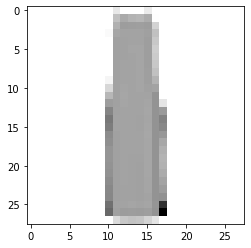

(60000, 28, 28)

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

X_train = tf.keras.utils.normalize(X_train, axis=1)
X_test = tf.keras.utils.normalize(X_test, axis=1)

plt.imshow(X_train[np.random.randint(0, X_train.shape[0])], cmap=plt.cm.binary)
plt.show()

X_train.shape

### CNN model

In [3]:
batch_size = 32
no_channels = 1

input_shape = (X_train.shape[1], X_train.shape[2], no_channels)

# sequential apif
# convolutional layers: specify no. conv filters (to give certain output shape), kernel dimensions
model = Sequential([
    Conv2D(64, (3, 3), input_shape=input_shape, activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(64, activation="relu"),

    Dense(10, activation="softmax")
])

# compile model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# fit model
model.fit(X_train, y_train, epochs=3, validation_split=0.2)

2022-05-27 16:22:38.390742: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/3
1500/1500 [==============================] - 35s 23ms/step - loss: 0.5096 - accuracy: 0.8120 - val_loss: 0.3816 - val_accuracy: 0.8601
Epoch 2/3
1500/1500 [==============================] - 35s 23ms/step - loss: 0.3439 - accuracy: 0.8735 - val_loss: 0.3513 - val_accuracy: 0.8699
Epoch 3/3
1500/1500 [==============================] - 38s 25ms/step - loss: 0.2969 - accuracy: 0.8910 - val_loss: 0.3031 - val_accuracy: 0.8863


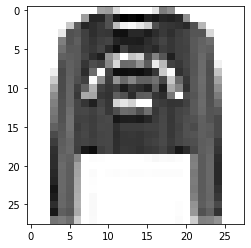

Predicted probabilities: [1.1630344e-03 3.8433045e-06 9.9573767e-01 4.0385621e-05 1.1440541e-03
 7.8111661e-06 1.8440720e-03 1.4148310e-07 5.5908200e-05 3.0805572e-06]

Predicted class: Pullover
True class: Pullover


In [5]:
def class_prediction(probabilities):
    return class_names[np.argmax(probabilities)]


# sample random test instance from test dataset
rand_index = np.random.randint(0, X_test.shape[0])
test_instance = X_test[rand_index]
plt.imshow(test_instance, cmap=plt.cm.binary)
plt.show()

test_instance = tf.constant(test_instance)
test_instance = tf.expand_dims(test_instance, 0)

# use our original model to make a class prediction on this image
prediction = model.predict(test_instance)

print("Predicted probabilities:", prediction[0])
print("\nPredicted class:", class_prediction(prediction[0]))
print("True class:", class_names[y_test[rand_index]])